# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
#!pip3 install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#!python -m pip install pyvirtualdisplay
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

In [4]:
from model import DuelQNetwork
import torch 
from collections import OrderedDict


In [5]:
env.reset()
action = 1
state, _, _, _ = env.step(0)
next_state, reward, done, _ = env.step(action)

states = torch.tensor([state])
next_states = torch.tensor([next_state])
states.size(), next_states.size()

(torch.Size([1, 8]), torch.Size([1, 8]))

In [6]:
action, reward

(1, 1.1421223673051497)

In [7]:
actions = torch.tensor([[action]])
rewards = torch.tensor([[reward]])
dones = torch.tensor([[done]])

In [8]:
gamma = 1.

# Check Dueling NetWork Architecture

In [9]:
qnet_rbow = DuelQNetwork(state_size=8, action_size=4, seed=123, hidden_layers=[1], drop_p=0.2)
qnet_rbow_target = DuelQNetwork(state_size=8, action_size=4, seed=123, hidden_layers=[1], drop_p=0.2)
qnet_rbow

DuelQNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): Linear(in_features=1, out_features=1, bias=True)
  )
  (out_val): Linear(in_features=1, out_features=1, bias=True)
  (out_adv): Linear(in_features=1, out_features=4, bias=True)
  (dropout): Dropout(p=0.2)
)

In [10]:


architecture_adv = OrderedDict([
    ('fc', qnet_rbow.hidden_layers[0]),
    ('adv', qnet_rbow.out_adv)
])

architecture_val = OrderedDict([
    ('fc', qnet_rbow.hidden_layers[0]),
    ('val', qnet_rbow.out_val)
])

qnet_rbow_adv = torch.nn.Sequential(architecture_adv)
qnet_rbow_val = torch.nn.Sequential(architecture_val)

In [11]:
x_adv = qnet_rbow_adv.forward(states)
x_adv

tensor([[ 0.7649, -0.1692,  0.3567,  0.8456]])

In [12]:
x_adv_mean = x_adv.mean()
x_adv_mean

tensor(0.4495)

In [13]:
x_val = qnet_rbow_val.forward(states)
x_val

tensor([[-0.9166]])

In [14]:
x_out = x_val + (x_adv - x_adv_mean)
x_out

tensor([[-0.6012, -1.5353, -1.0095, -0.5205]])

# Check Double Q-Net

Local Q-net

In [15]:
qnet_rbow.forward(states)

tensor([[ 0.2341, -0.4207, -0.0997,  0.2864]])

In [16]:
ps_local = qnet_rbow.forward(states).gather(1, actions)
ps_local

tensor([[-0.4207]])

Target Q-net

In [17]:
ps_actions =qnet_rbow.forward(next_states).detach().max(dim=1)[1].view(-1, 1)
ps_actions

tensor([[ 3]])

In [18]:
rewards

tensor([[ 1.1421]])

In [19]:
 gamma * (1 - dones)

tensor([[ 1]], dtype=torch.uint8)

In [20]:
qnet_rbow_target.forward(next_states).detach().gather(1, ps_actions)

tensor([[ 0.2864]])

In [21]:
ps_target = rewards + gamma * (1 - dones).float() * qnet_rbow_target.forward(next_states).detach().gather(1, ps_actions)
ps_target

tensor([[ 1.4285]])

In [22]:
qnet_rbow_target.forward(states)#.detach().max(dim=1)[1].view(-1, 1)

tensor([[ 0.2341, -0.4207, -0.0997,  0.2864]])

In [23]:
from dqn_agent import AgentDQ, AgentDuelDQ

agent_dq = AgentDQ(state_size=8, action_size=4, gamma=0.99, hidden_layers=[64,32], drop_p=0.2,
                 batch_size=64, learning_rate=5e-4, soft_upd_param=1e-3, update_every=4, buffer_size=int(1e5), seed=123)

agent_dueldq = AgentDuelDQ(state_size=8, action_size=4, gamma=0.99, hidden_layers=[64,32], drop_p=0.2,
                 batch_size=64, learning_rate=5e-4, soft_upd_param=1e-3, update_every=4, buffer_size=int(1e5), seed=123)


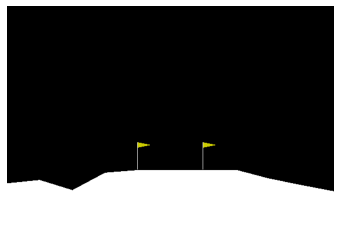

In [24]:

hist = []
# watch an untrained agent
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(200):
    
    action = agent_dq.act(state)
    exp = (state, action)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    exp = exp + (reward,)
    hist.append(exp)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [25]:
from dqn import train

In [ ]:
scores_dq = train(env, agent_dq, n_episodes=2000, max_t=1000, 
        eps_start=1.0, eps_end=0.01, eps_decay=0.995, model_save_path='dq_checkpoint.pth')

Episode 100	Average Score: -166.99
Episode 200	Average Score: -62.921
Episode 293	Average Score: -12.70

In [ ]:
scores_dueldq = train(env, agent_dueldq, n_episodes=2000, max_t=1000, 
        eps_start=1.0, eps_end=0.01, eps_decay=0.995, model_save_path='rbow_checkpoint.pth')

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
pathname = 'checkpoint.pth'

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

checkpoint = torch.load(pathname, map_location=map_location)

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(checkpoint)

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  